In [34]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)
import numpy as np
import imageio
from scipy.ndimage import filters
from scipy import io

Populating the interactive namespace from numpy and matplotlib


In [35]:
Inputs = [
    './beer_coke_inp.bmp',
    './cups_board_inp.bmp',
    './people_inp.bmp'
]

Images = map(imageio.imread, Inputs)
Images = map(lambda Image: Image.astype(np.float) / 255.0, Images)

DepthFilters = []
for i in range(9):
    filterFName = './CodedApertureData/filts/filt_scl%02d.mat' % (i + 1)
    DepthFilters.append(io.loadmat(filterFName)['filts'][0][3])

In [38]:
ImageIndex = 0

def PixelError(Window):
    return np.sum(Window)

ResultImages = []
DepthMaps = []
for Input in Inputs:
    Deblurred = []
    for Index in range(9):
        Deblurred.append(io.loadmat("%s_%d" % (Input, Index + 1))['deblurred'])
        
    TargetImage = Images[ImageIndex]
    
    ErrorsR = map(lambda i: (TargetImage[:, :, 0] - filters.convolve(Deblurred[i][:, :, 0], DepthFilters[i], mode='reflect')) ** 2, range(9))
    ErrorsG = map(lambda i: (TargetImage[:, :, 1] - filters.convolve(Deblurred[i][:, :, 1], DepthFilters[i], mode='reflect')) ** 2, range(9))
    ErrorsB = map(lambda i: (TargetImage[:, :, 2] - filters.convolve(Deblurred[i][:, :, 2], DepthFilters[i], mode='reflect')) ** 2, range(9))
    
    PxErrorsR = map(lambda i: filters.generic_filter(ErrorsR[i], PixelError, size=(3, 3), mode='reflect'), range(9))
    PxErrorsG = map(lambda i: filters.generic_filter(ErrorsG[i], PixelError, size=(3, 3), mode='reflect'), range(9))
    PxErrorsB = map(lambda i: filters.generic_filter(ErrorsB[i], PixelError, size=(3, 3), mode='reflect'), range(9))
    
    BestR = np.argmin(PxErrorsR, axis=0)
    BestG = np.argmin(PxErrorsG, axis=0)
    BestB = np.argmin(PxErrorsB, axis=0)
    
    AllInFocusImage = np.zeros_like(TargetImage)
    
    for h in range(AllInFocusImage.shape[0]):
        for w in range(AllInFocusImage.shape[1]):
            AllInFocusImage[h, w, 0] = Deblurred[BestR[h, w]][h, w, 0]
            AllInFocusImage[h, w, 1] = Deblurred[BestG[h, w]][h, w, 1]
            AllInFocusImage[h, w, 2] = Deblurred[BestB[h, w]][h, w, 2]
    
    DepthMaps.append(BestR)
    ResultImages.append(AllInFocusImage)

    ImageIndex += 1
    

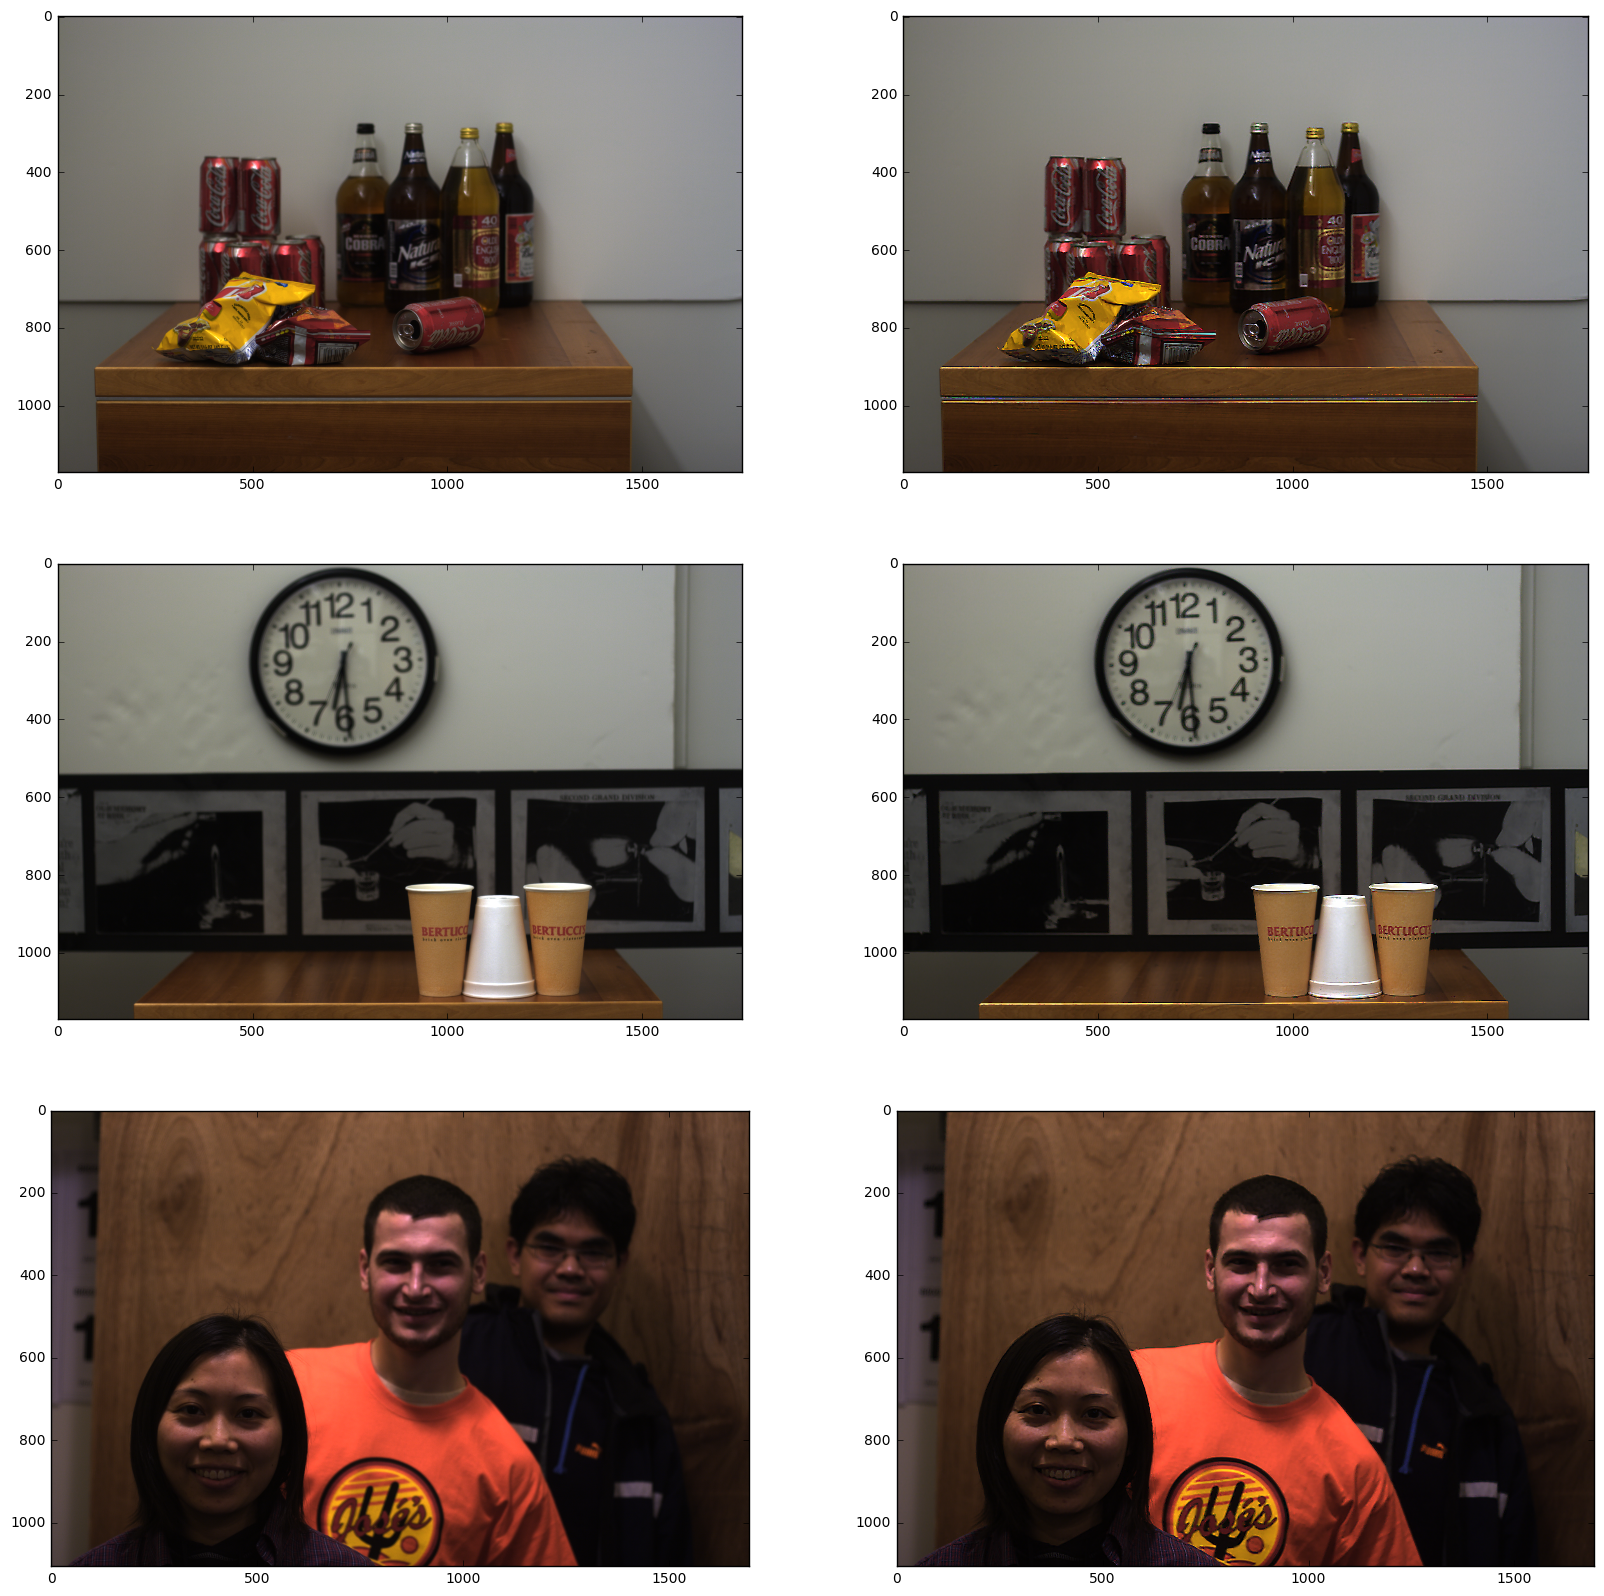

In [39]:
for i in range(3):    
    subplot(3, 2, (i * 2) + 1)
    imshow(Images[i])
    subplot(3, 2, (i * 2) + 2)
    imshow(np.clip(ResultImages[i], 0, 1))
    imageio.imsave("%s_deblurred.bmp" % Inputs[i], np.clip(ResultImages[i], 0, 1))

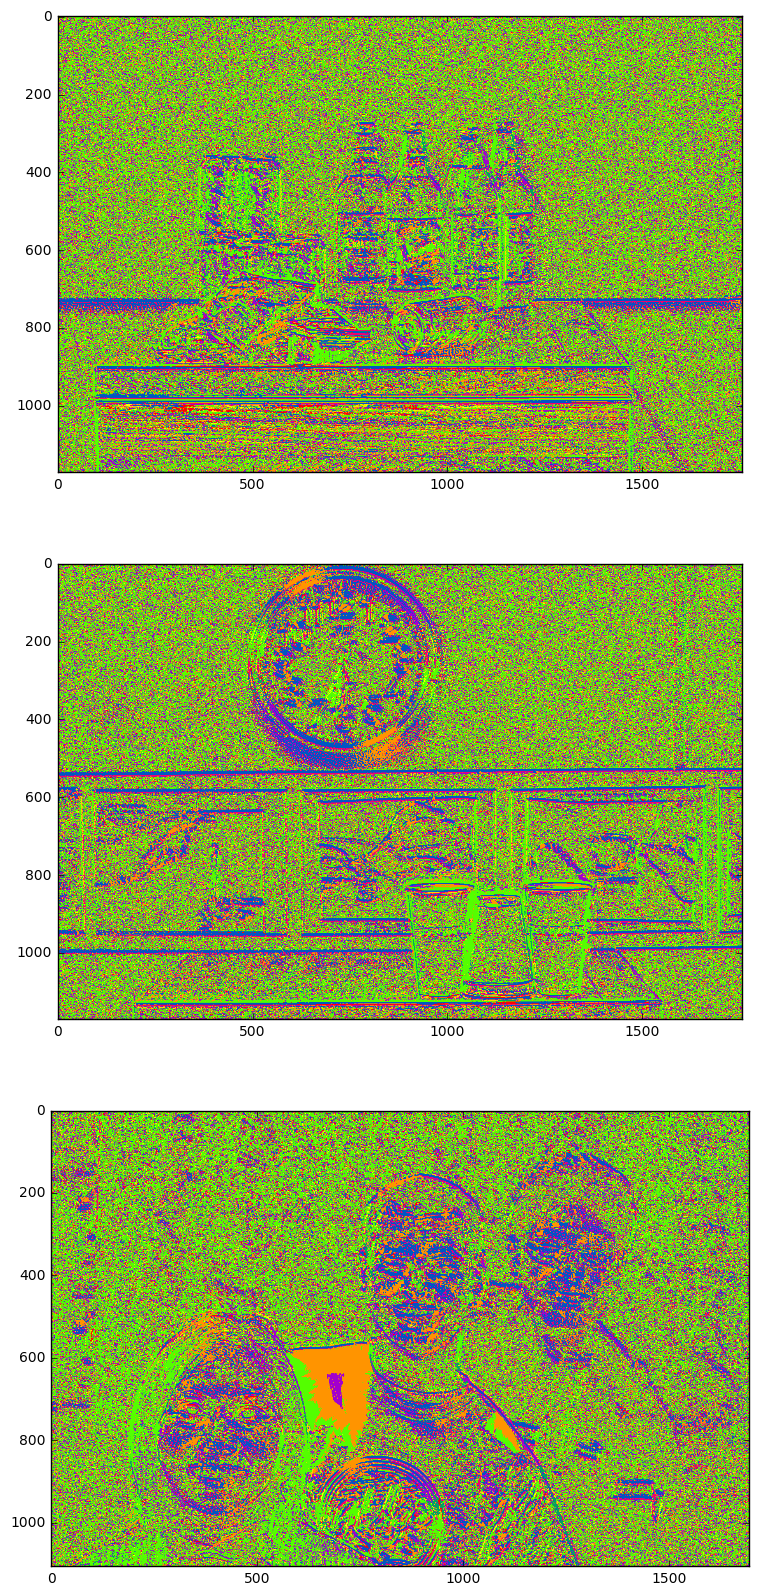

In [40]:
for i in range(3):
    subplot(3, 1, i+1)
    imshow(DepthMaps[i] / 9.0, cmap='prism')